# Win Prediction from Team's Stats at 10-min Mark


This notebook investigate '10mins_stats.csv' file to find analyze various factors/objectives at 10-min timestamp which contribute to the team's success. The csv file consists of team's overall stats such as team kills, team total gold, etc., and the label whether the time managed to end the game with a win or loss.
## 1. Data Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('datasets/10mins_stats.csv')
df.head()

,matchId,blue_wins,blue_kills,blue_assists,blue_deaths,blue_wards_placed,blue_wards_kills,blue_dragon_kills,blue_herald_kills,blue_tower_kills,...,red_wards_placed,red_wards_kills,red_dragon_kills,red_herald_kills,red_tower_kills,red_inhibitor_kills,red_total_gold,red_average_lvl,red_total_exp,red_total_cs
0,NA1_4134639110,False,11,16,15,17,5,1,0,0,...,17,7,0,0,0,0,21912,7.6,21428,302
1,NA1_4135794736,False,3,4,16,18,4,0,1,0,...,17,4,1,0,0,0,22520,8.0,22244,341
2,NA1_4136156707,False,6,5,11,20,3,0,0,0,...,20,2,1,0,0,0,20789,7.6,21383,304
3,NA1_4136537752,True,16,16,14,13,3,0,0,0,...,17,2,0,1,0,0,21596,7.8,21039,282
4,NA1_4137045009,True,12,14,8,16,2,1,0,0,...,13,0,0,0,0,0,18154,7.2,19753,290


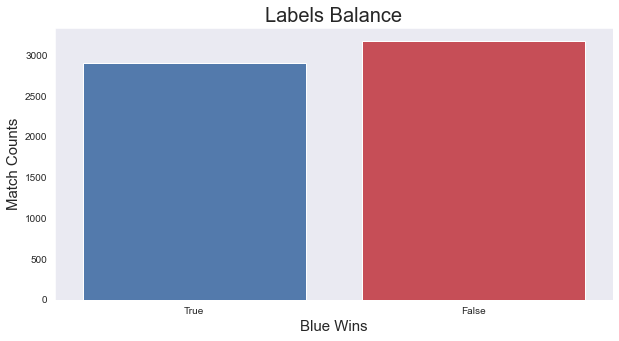

In [4]:
data = df.groupby('blue_wins')['matchId'].count()

sns.set_style('dark')

plt.figure(figsize=(10,5))
sns.barplot(y=data, x=data.index, order=[True, False], palette=sns.diverging_palette(250, 10, n=2))
plt.xlabel('Blue Wins', size=15)
plt.ylabel('Match Counts', size=15)
plt.title('Labels Balance', size=20)
plt.show()

From the graph, the number of matches in the dataset where blue wins/loses is relatively equal. Thus, the data is fairly balanced.

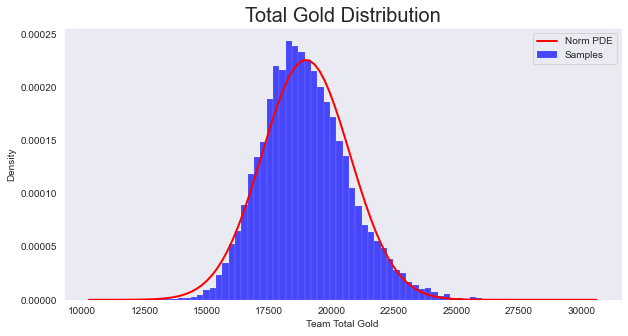

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set_style('dark')

data = pd.concat([df['blue_total_gold'], df['red_total_gold']])
sns.histplot(data, color='b', bins=80, alpha=0.7, lw=0.1, ax=ax, kde=False, stat='density', label='Samples')

x_pdf = np.linspace(data.min(), data.max(), 100)
y_pdf = norm.pdf(x_pdf, norm.fit(data)[0], norm.fit(data)[1])
plt.plot(x_pdf, y_pdf, 'r', lw=2, label='Norm PDE')

plt.xlabel('Team Total Gold')
plt.ylabel('Density')
plt.title('Total Gold Distribution', size=20)
plt.legend()

plt.show()

The distribution of golds fits fairly well to normal distribution curve with mean of around 18000-19000 total gold at 10-min mark of a match.

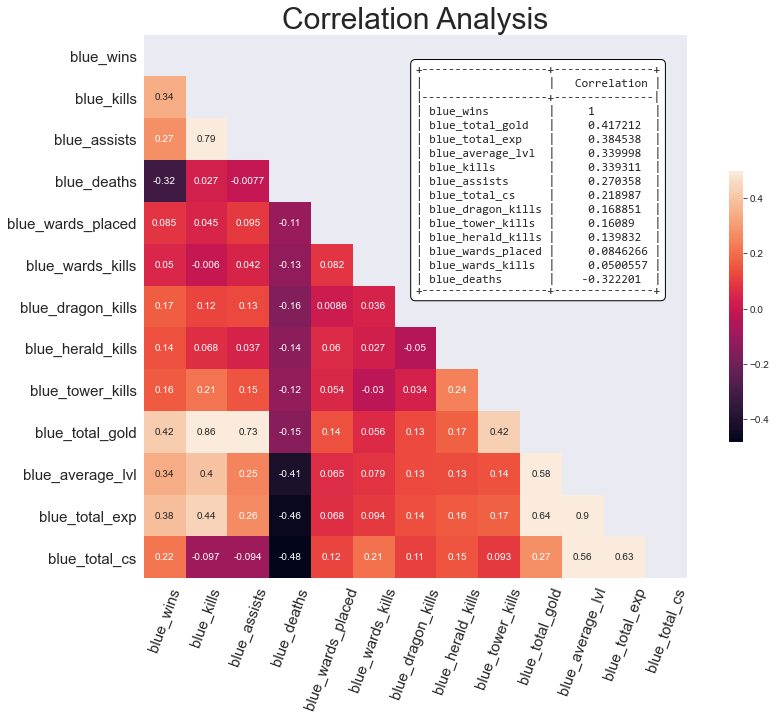

In [14]:
corr = df[df.columns[:15]].drop(['blue_inhibitor_kills'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15,10))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=None, vmax=0.5, square=True, annot=True, cbar_kws={'shrink':.5}, ax=ax)
ax.tick_params(axis='x', rotation=70, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title('Correlation Analysis', fontsize=30)

text = tabulate(corr['blue_wins'].sort_values(ascending=False).rename('Correlation').to_frame(),
                headers='keys',
                tablefmt='psql'
               )
plt.text(6.5, 6.2, text,
         fontsize=12,
         bbox=dict(boxstyle="round, pad=0.4", fc="white", ec="black", lw=1),
         **{'fontname':'Consolas'}
        )

plt.show()

Correlation plot shows that team total gold and total experience point at 10-min mark are the most important numbers, even more important than kills, that largely increase the chance of winning at the end of the match. Notes that team total exp. and average level are highly correlated to each other so we can drop 'team_average_lvl' column since it's less correlated to the match final result.

Another interesting observation is large negative correlations between deaths and team total cs, total exp, and average level. That means dying in League of Legends considerably widen the gap between both teams' levels and total creep scores. However, dying doesn't really affect the total gold at all as the disadvantaged team is more likely to lose because of lower levels. By the ways, dying a lot can still put your team behind the opponents as seen by negative correlations with every other features.

## 2. Data Preprocessing & Preparation

- Most of the preparation/cleaning was already done during dataset generation in riot_api_test.ipynb
- Drop 'team_average_level' column due to high correlation with 'team_total_exp'
- Scale values in all of the columns down to range 0-1

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

training_df = df.drop(['blue_average_lvl', 'red_average_lvl', 'matchId'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(training_df.drop('blue_wins', axis=1),
                                                    training_df['blue_wins'],
                                                    test_size=0.2,
                                                    shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## 3. Machine Learning Model Selection

For this win prediction problem, there is 2 possible outcome: blue team winning or losing. The problem can be formulated as a simple binary classification problems where each team stats are equivalent to features for predicting the win/lose label. A total of 7 common models for classification problems are investigated and compared by each of the model's accuracy, and the result is then visualized for easy intepretation.

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

import itertools

In [39]:
list(dict.fromkeys(itertools.permutations([1,1,1,1,1,1,1,2,2,2,2,2,2], 7)))

127

Fit each of the model with X_train and y_train from the dataset with cross validation (cv=5) and visualize the average performance with bar charts.

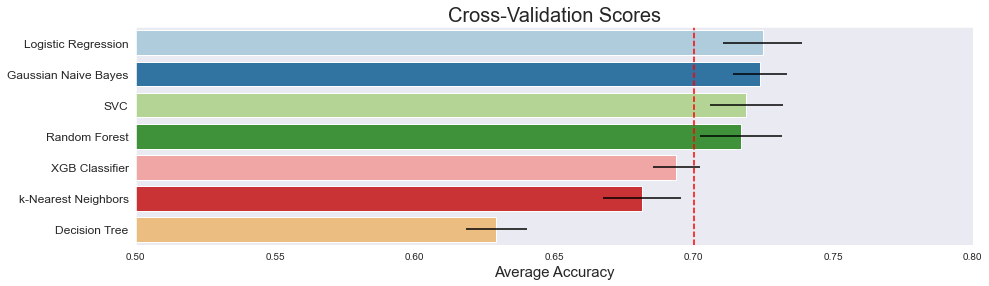

In [18]:
random_state = 69

clf_list_names = ['Gaussian Naive Bayes',
                  'Logistic Regression',
                  'k-Nearest Neighbors',
                  'SVC',
                  'Decision Tree',
                  'Random Forest',
                  'XGB Classifier']

clf_list = [GaussianNB(), 
            LogisticRegression(random_state = random_state),
            KNeighborsClassifier(), 
            SVC(random_state = random_state, probability = True),
            DecisionTreeClassifier(random_state = random_state), 
            RandomForestClassifier(random_state = random_state),
            XGBClassifier(random_state = random_state, objective='binary:logistic', eval_metric='error', use_label_encoder=False),]

cv_mean = []
cv_std = []
test_mean = []

# Fit each classifier one by one with cross-validation and store the result performance
for clf in clf_list:  
    cv = cross_val_score(clf, X_train_scaled, y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)
    cv_mean.append(cv.mean())
    cv_std.append(cv.std())

# Convert result list into Pandas DataFrame
cv_score_by_clf = pd.DataFrame({'Algorithm': clf_list_names,
                                  'CV-Means': cv_mean,
                                  'CV-SDs': cv_std}).sort_values('CV-Means', ascending=False)


# Visualize the result
plt.figure(figsize=(15,4))
                       
sns.barplot(data = cv_score_by_clf,
            x='CV-Means',
            y='Algorithm',
            palette = 'Paired',
            orient = 'h',
            **{'xerr': cv_score_by_clf['CV-SDs']})

plt.xlabel('Average Accuracy', fontsize=15)
plt.ylabel('')
plt.title('Cross-Validation Scores', fontsize=20)
plt.yticks(size=12)

plt.xlim([0.5, 0.8])
plt.axvline(x = 0.7, color = 'r', linestyle = '--');
plt.show()

From the graph above, it can be seen that Logistic Regression, SVC, and GNB perform equally well as observed from relatively similar average accuracy of around 73%. Apart fromo that, every model yields similar standard deviation values while decision tree results in the worst performance and accuracy among all 7 architectures.

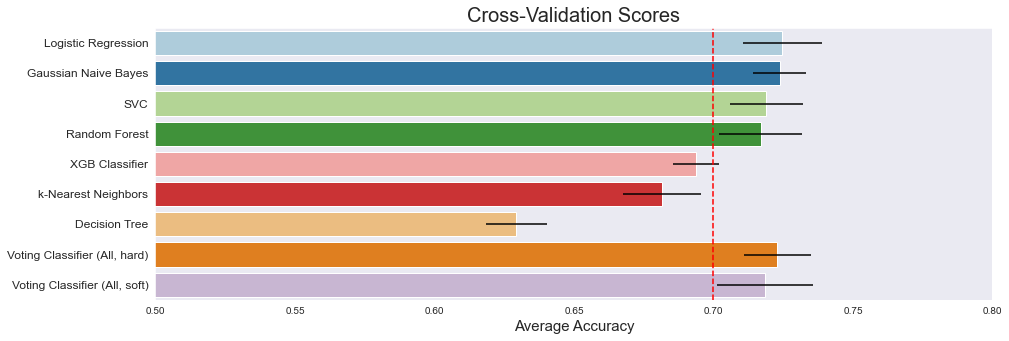

In [19]:
estimators = [('gnb', clf_list[0]),
              ('lr', clf_list[1]),
              ('knn', clf_list[2]),
              ('svc', clf_list[3]),
              ('dt', clf_list[4]),
              ('rf', clf_list[5]),
              ('xgb', clf_list[6])]

# Initialize voting classifiers
hard_voting_clf = VotingClassifier(estimators, voting='hard')
soft_voting_clf = VotingClassifier(estimators, voting='soft')

cv_voting_hard = cross_val_score(hard_voting_clf, X_train_scaled, y_train, cv=5, n_jobs = -1)
cv_voting_soft = cross_val_score(soft_voting_clf, X_train_scaled, y_train, cv=5, n_jobs = -1)

cv_score_voting = pd.DataFrame({'Algorithm': ['Voting Classifier (All, hard)', 'Voting Classifier (All, soft)'],
                                    'CV-Means': [cv_voting_hard.mean(), cv_voting_soft.mean()], 
                                    'CV-SDs': [cv_voting_hard.std(), cv_voting_soft.std()]})

cv_score_by_clf_all = pd.concat([cv_score_by_clf, cv_score_voting], axis=0, ignore_index=True)


# Plot the result
plt.figure(figsize=(15,5))
                       
sns.barplot(data = cv_score_by_clf_all,
            x='CV-Means',
            y='Algorithm',
            palette = 'Paired',
            orient = 'h',
            **{'xerr': cv_score_by_clf_all['CV-SDs']})

plt.xlabel('Average Accuracy', fontsize=15)
plt.ylabel('')
plt.title('Cross-Validation Scores', fontsize=20)
plt.yticks(size=12)

plt.xlim([0.5, 0.8])
plt.axvline(x = 0.7, color = 'r', linestyle = '--');
plt.show()

From the bar charts, the performance of ensembled voting classifiers remains relatively unchanged for both soft and hard voting. This might happen because all of the estimators are fitted into the same direction so that combining them doesn't change the result.

### Hyperparameters Tuning
Using sklearn's GridSearchCV, various parameter configurations are tested and compared for each model to determine the best parameters for each respective model. The accuracy of the tuned models is then plotted beside the pre-tuned counterparts to clearly see the change in performance.

In [43]:
# Define ranges of parameters to be evaluated

param_grid = {'Gaussian Naive Bayes': dict(var_smoothing=np.logspace(0, -9, num=20, base=10)), 
              'Logistic Regression': dict(max_iter=[100],
                                          penalty=['l1', 'l2'],
                                          C=np.logspace(-2,2,20),
                                          solver=['lbfgs', 'liblinear']),
              'k-Nearest Neighbors': dict(n_neighbors=np.arange(3, 30, 2),
                                          weights=['uniform', 'distance'],
                                          algorithm=['auto'],
                                          p=[1, 2]),
              'SVC': [dict(kernel=['rbf'], gamma=[0.01, 0.1, 0.5, 1, 2, 5], C=[.1, 1, 2, 5]),
                      dict(kernel=['linear'], C=[.1, 1, 2, 10]),
                      dict(kernel=['poly'], degree=[2, 3, 4, 5], C=[.1, 1, 10])
                     ],
              'Decision Tree': dict(max_depth=[3, 5, 10, 20, 50],
                                    criterion=['entropy', 'gini'],
                                    min_samples_split=[5, 10, 15, 30],
                                    max_features=[None, 'auto', 'sqrt', 'log2']),
              'Random Forest': dict(n_estimators=[50, 150, 300, 450],
                                    criterion=['entropy'],
                                    bootstrap=[True],
                                    max_depth=[3, 5, 10],
                                    max_features=['auto','sqrt'],
                                    min_samples_leaf=[2, 3],
                                    min_samples_split=[2, 3]),
              'XGB Classifier': dict(n_estimators=[15, 25, 50, 100],
                                     colsample_bytree=[0.65, 0.75, 0.80],
                                     max_depth=[None],
                                     reg_alpha=[1],
                                     reg_lambda=[1, 2, 5],
                                     subsample=[0.50, 0.75, 1.00],
                                     learning_rate=[0.01, 0.1, 0.5],
                                     gamma=[0.5, 1, 2, 5],
                                     min_child_weight=[0.01],
                                     sampling_method=['uniform']),
              'voting_weights': dict(weights=list(dict.fromkeys(itertools.permutations([1,1,1,1,1,1,1,2], 7))))
             }


Grid seach through the range of defined hyperparameters and store the best version of each type of classifier. Also, store each model with best parameter configuration for constructing voting classifier in the next cell.

In [22]:
cv_mean_tuned = []
clf_list_tuned = []
test_mean = []

# Grid search each estimator one by one and store the new average accuracy for each tuned model
for clf_name, clf in zip(clf_list_names, clf_list):
    print('==========================================================')
    print(f'Grid Searching for {clf_name}....')
    
    grid_search = GridSearchCV(estimator=clf,
                               param_grid=param_grid[clf_name],
                               cv=5,
                               verbose=0,
                               n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_pred, y_test)
    
    print(f'Best Score (Training)\t: {grid_search.best_score_:.3f}')
    print(f'Testing Accuracy Score\t: {accuracy:.3f}')
    print(f'Best Params : {grid_search.best_params_}')
    
    cv_mean_tuned.append(grid_search.best_score_)
    clf_list_tuned.append(grid_search.best_estimator_)
    test_mean.append(accuracy)


cv_score_by_clf_tuned_ = pd.DataFrame({'Algorithm': clf_list_names,
                                      'CV-Means-tuned': cv_mean_tuned,
                                       'Testing Accuracy': test_mean})
cv_score_by_clf_tuned = pd.merge(cv_score_by_clf, cv_score_by_clf_tuned_, on='Algorithm').set_index('Algorithm').drop('CV-SDs', axis=1)
# cv_score_by_clf_tuned['+ Accuracy'] = (cv_score_by_clf_tuned['CV-Means-tuned'] - cv_score_by_clf_tuned['CV-Means'])

display(cv_score_by_clf_tuned.style.set_properties(**{'background-color': '#D1FFD9'}, subset=['Testing Accuracy']))

Grid Searching for Gaussian Naive Bayes....
Best Score (Training)	: 0.728
Testing Accuracy Score	: 0.735
Best Params : {'var_smoothing': 1.0}
Grid Searching for Logistic Regression....
Best Score (Training)	: 0.728
Testing Accuracy Score	: 0.737
Best Params : {'C': 0.06951927961775606, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Grid Searching for k-Nearest Neighbors....
Best Score (Training)	: 0.720
Testing Accuracy Score	: 0.715
Best Params : {'algorithm': 'auto', 'n_neighbors': 29, 'p': 1, 'weights': 'distance'}
Grid Searching for SVC....
Best Score (Training)	: 0.728
Testing Accuracy Score	: 0.738
Best Params : {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Grid Searching for Decision Tree....
Best Score (Training)	: 0.713
Testing Accuracy Score	: 0.710
Best Params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 5}
Grid Searching for Random Forest....
Best Score (Training)	: 0.729
Testing Accuracy Score	: 0.726
Best Params : {'bootstra

,CV-Means,CV-Means-tuned,Testing Accuracy
Algorithm,,,
Logistic Regression,0.724713,0.728414,0.737058
Gaussian Naive Bayes,0.723685,0.728003,0.735415
SVC,0.718957,0.728003,0.737880
Random Forest,0.716899,0.729028,0.726376
XGB Classifier,0.693873,0.728413,0.725555
k-Nearest Neighbors,0.681543,0.720395,0.714873
Decision Tree,0.629315,0.712582,0.709942


By using the list of all tuned models, construct soft and hard voting classifier, considering voting classifier with different voting weights, and compute the testing accuracy.

Grid Searching for Hard Voting Classifiers....
Best Score (Training)	: 0.732
Testing Accuracy Score	: 0.734
Best Params : {'weights': (1, 1, 1, 1, 2, 1, 1)}
Grid Searching for Soft Voting Classifiers....
Best Score (Training)	: 0.730
Testing Accuracy Score	: 0.558
Best Params : {'weights': (1, 1, 2, 1, 1, 1, 1)}


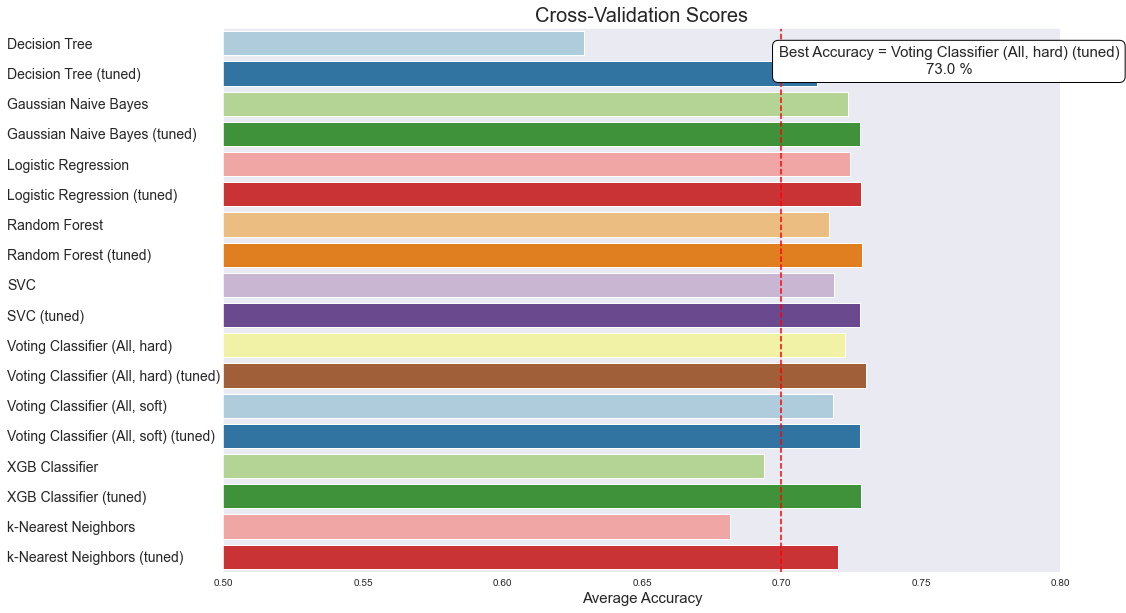

In [44]:
estimators_tuned = [('gnb', clf_list_tuned[0]),
                    ('lr', clf_list_tuned[1]),
                    ('knn', clf_list_tuned[2]),
                    ('svc', clf_list_tuned[3]),
                    ('dt', clf_list_tuned[4]),
                    ('rf', clf_list_tuned[5]),
                    ('xgb', clf_list_tuned[6])]

hard_voting_clf_tuned = VotingClassifier(estimators_tuned, voting='hard')
soft_voting_clf_tuned = VotingClassifier(estimators_tuned, voting='soft')

grid_search_hard = GridSearchCV(hard_voting_clf_tuned,
                                param_grid = param_grid['voting_weights'],
                                cv = 5,
                                verbose = False,
                                n_jobs = -1)
grid_search_soft = GridSearchCV(soft_voting_clf_tuned,
                                param_grid = param_grid['voting_weights'],
                                cv = 5,
                                verbose = False,
                                n_jobs = -1)

# cv_voting_hard_tuned = cross_val_score(hard_voting_clf_tuned, X_train_scaled, y_train, cv=5, n_jobs = -1)
# cv_voting_soft_tuned = cross_val_score(soft_voting_clf_tuned, X_train_scaled, y_train, cv=5, n_jobs = -1)

print('Grid Searching for Hard Voting Classifiers....')
grid_search_hard.fit(X_train_scaled, y_train)
y_pred_hard = grid_search_hard.predict(X_test_scaled)
print(f'Best Score (Training)\t: {grid_search_hard.best_score_:.3f}')
print(f'Testing Accuracy Score\t: {accuracy_score(y_pred_hard, y_test):.3f}')
print(f'Best Params : {grid_search_hard.best_params_}')

print('Grid Searching for Soft Voting Classifiers....')
grid_search_soft.fit(X_train_scaled, y_train)
y_pred_soft = grid_search_soft.predict(X_test)
print(f'Best Score (Training)\t: {grid_search_soft.best_score_:.3f}')
print(f'Testing Accuracy Score\t: {accuracy_score(y_pred_soft, y_test):.3f}')
print(f'Best Params : {grid_search_soft.best_params_}')

cv_score_voting_tuned = pd.DataFrame({'Algorithm': ['Voting Classifier (All, hard)', 'Voting Classifier (All, soft)'],
                                      'CV-Means-tuned': [cv_voting_hard_tuned.mean(), cv_voting_soft_tuned.mean()],
                                      'Testing Accuracy': [accuracy_score(y_pred_hard, y_test), accuracy_score(y_pred_soft, y_test)],
                                      'CV-SDs': [cv_voting_hard_tuned.std(), cv_voting_soft_tuned.std()]})

cv_score_by_clf_all_tuned = pd.concat([cv_score_by_clf_tuned_, cv_score_voting_tuned], axis=0, ignore_index=True)
cv_score_by_clf_all_tuned = cv_score_by_clf_all_tuned.rename({'CV-Means-tuned': 'CV-Means'}, axis=1)
cv_score_by_clf_all_tuned['Algorithm'] = cv_score_by_clf_all_tuned['Algorithm'].apply(lambda x: x + ' (tuned)')

cv_score_all = pd.concat([cv_score_by_clf_all, cv_score_by_clf_all_tuned]).sort_values('Algorithm')


# Visualize the comparision between pre- and post-tuning models
plt.figure(figsize=(15,10))
                       
sns.barplot(data = cv_score_all,
            x='CV-Means',
            y='Algorithm',
            palette=sns.color_palette('Paired', 20),
            orient='h',
           )

plt.xlabel('Average Accuracy', fontsize=15)
plt.ylabel('')
plt.title('Cross-Validation Scores', fontsize=20)
plt.yticks(size=14, horizontalalignment='left', x=-0.25)

plt.xlim([0.5, 0.8])
plt.axvline(x = 0.7, color = 'r', linestyle = '--');
plt.text(0.76, 1,
         f"Best Accuracy = {cv_score_all.nlargest(1, 'CV-Means')['Algorithm'].item()}\n{cv_score_all['CV-Means'].max()*100:.1f} %",
         size=15,
         horizontalalignment='center',
         bbox=dict(boxstyle="round, pad=0.4", fc="white", ec="black", lw=1)
        )
plt.show()

From the result, it can be seen that each type of classifier can still be improved through hyperparameter tuning, especially for decision tree where the accuracy increases by almost 10%. The top performance of around 73 % accuracy by almost every type of classifiers suggest that the team total stats at 10-min mark might not give enough information for a complete win/lose prediction. This can happen because of the following reasons,
- At 10 minutes, the difference between both team might be still unclear whether which team is leading or losing
- The prediction didn't take team composition (choices of champions in each team) into the consideration
- Even though a team is leading at 10-min mark, the table can still turn as LoL is fairly an unpredictable game where anything can happen